In [1]:
import splitfolders
splitfolders.ratio("train", "data", ratio = (0.97, 0.03))

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import math
import splitfolders
val = splitfolders.ratio("train", "data", ratio = (0.97, 0.03))
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
batch_size = 50
val_size = 75
dataset = torchvision.datasets.ImageFolder(root="data/train",transform = transform)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
val_set = torchvision.datasets.ImageFolder(root="data/val",transform = transform)
val_loader = DataLoader(val_set, batch_size = val_size, shuffle = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


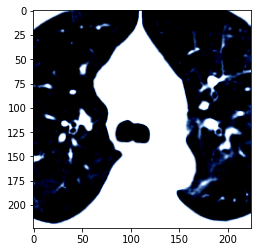

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


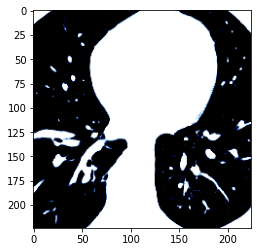

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


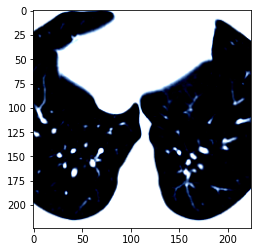

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


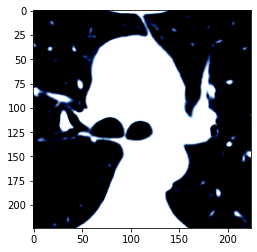

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


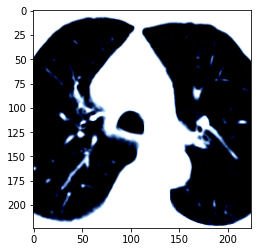

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


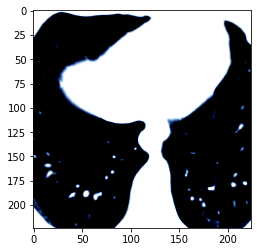

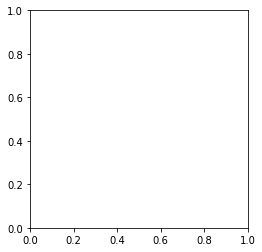

In [2]:
import matplotlib.pyplot as plt
try:
    for i in loader:
        img = i[0][0].permute(1, 2, 0)
        plt.imshow(img)#ct scans of lung cross sections
        plt.show()#looks different like this because they are normalized
except KeyboardInterrupt:
    None

In [10]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(25088,5000)
        self.ac1 = nn.PReLU(1, 0.01)
        self.fc2 = nn.Linear(2048,5000)
        self.fc3 = nn.Linear(5000, 2)
        self.vgg = nn.Sequential(*(list(models.vgg16(pretrained = True).children())[:-1]))
        self.resnet = nn.Sequential(*(list(models.resnet50(pretrained = True).children())[:-1]))
    def forward(self, data):
        with torch.no_grad():
            vgg = self.vgg.cuda()
            data = data.cuda()
            x = vgg(data)#memory trick because I cannot fit both vgg and resnet on my gpu memory
            vgg.cpu()
            torch.cuda.empty_cache()
            resnet = self.resnet.cuda()
            x = x.reshape(data.shape[0], -1).cpu(), resnet(data).reshape(data.shape[0], -1).cpu()
            resnet.cpu()
            del data
            torch.cuda.empty_cache()
        x = torch.add(self.fc1(x[0]), self.fc2(x[1]))
        x = self.ac1(x)
        x = self.fc3(x)
        return x
model = net()


In [4]:
def evaluate(model, data, target):
    with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        acc = (torch.sum(torch.argmax(output, dim = 1)==target)/val_size).item()
        del output
        torch.cuda.empty_cache()
        print("Validation Loss",loss.item())
        print("Validation Accuracy", acc, "\n")

        return loss

Loss 0.7173011898994446
Accuracy 0.46000000834465027
Validation Loss 2.2419114112854004
Validation Accuracy 0.7733333110809326 

Loss 2.801548719406128
Accuracy 0.699999988079071
Validation Loss 19.193986892700195
Validation Accuracy 0.5066666603088379 

Loss 22.0031795501709
Accuracy 0.41999998688697815
Validation Loss 10.736062049865723
Validation Accuracy 0.5333333611488342 

Loss 11.402100563049316
Accuracy 0.5600000023841858
Validation Loss 9.355155944824219
Validation Accuracy 0.54666668176651 

Loss 10.441235542297363
Accuracy 0.5199999809265137
Validation Loss 1.6245490312576294
Validation Accuracy 0.7599999904632568 

Loss 1.090968132019043
Accuracy 0.8799999952316284
Validation Loss 6.6393141746521
Validation Accuracy 0.6000000238418579 

Loss 5.7468485832214355
Accuracy 0.6200000047683716
Validation Loss 6.068428993225098
Validation Accuracy 0.6133333444595337 

Loss 6.631622791290283
Accuracy 0.5199999809265137
Validation Loss 1.4855501651763916
Validation Accuracy 0.759999

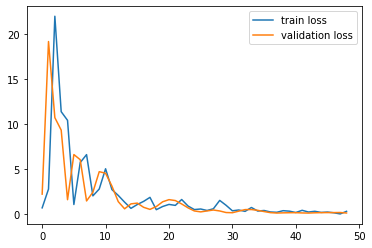

Time:  1613184273.3306775
Loss 0.08696960657835007
Accuracy 0.9800000190734863
Validation Loss 0.12958002090454102
Validation Accuracy 0.9333333373069763 

Loss 0.08385692536830902
Accuracy 0.9599999785423279
Validation Loss 0.1330917924642563
Validation Accuracy 0.9599999785423279 

Loss 0.13534517586231232
Accuracy 0.8999999761581421
Validation Loss 0.12884056568145752
Validation Accuracy 0.9599999785423279 

Loss 0.16693496704101562
Accuracy 0.9399999976158142
Validation Loss 0.11701899021863937
Validation Accuracy 0.9333333373069763 

Loss 0.0606498196721077
Accuracy 0.9800000190734863
Validation Loss 0.13229143619537354
Validation Accuracy 0.9200000166893005 

Loss 0.08987149596214294
Accuracy 0.9599999785423279
Validation Loss 0.1343189924955368
Validation Accuracy 0.9200000166893005 

Loss 0.06793702393770218
Accuracy 0.9599999785423279
Validation Loss 0.13505244255065918
Validation Accuracy 0.9200000166893005 

Loss 0.09570815414190292
Accuracy 0.9399999976158142
Validation Los

In [11]:
import torch.optim as optim
import math
import time
train_arr = []
val_arr = []
opt = optim.Adam(model.parameters(), 0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10
try:
    seconds = time.time()
    for epoch in range(epochs):
        for batch,target in loader:
            model.zero_grad()
            output = model(batch)
            loss = criterion(output, target)
            loss.backward()
            opt.step()
            print("Loss",loss.item())
            print("Accuracy", (torch.sum(torch.argmax(output, dim = 1)==target)/batch_size).item())
            for batch,target in val_loader:
                val_loss = evaluate(model, batch, target)
            train_arr.append(loss.item())
            val_arr.append(val_loss.item())
        plt.plot(range(len(train_arr)), train_arr, label = "train loss")#plot graph at epoch end
        plt.plot(range(len(val_arr)), val_arr, label = "validation loss")
        plt.legend()
        plt.show()
        print("Time: ",seconds)
except KeyboardInterrupt:
    None